# Demonstrating Gradient Descent with Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from algorithms.gd import basic_gd, gd
from algorithms.sgd import batch_sgd, batch_sgd_projection

In [2]:
sns.set_style("whitegrid")
dpi = 200

## Binary Classifier Problem

We consider a binary classification problem with inputs $x \in \mathbb{R}$ and outputs $y \in \{ 0,1 \}$. We use a **logistic regression** model so we have the prediction rule: 
$$h_w(x)=\frac{\exp \left(w^{\top} x\right)}{1+\exp \left(w^{\top} x\right)}$$

### Synthetic data

In [3]:
# Data Generating Model
def data_generating_model(n, w):
    np.random.seed(42)
    z = np.empty((n, 2))
    z[:, 0] = np.random.uniform(-10, 10, size=n)
    p = w[0] + w[1] * z[:, 0]
    p = np.exp(p) / (1 + np.exp(p))
    z[:, 1] = np.random.binomial(1, p, size=n)
    return z

n_obs = 1000
w_true = np.array((0, 1))
z_obs = data_generating_model(n_obs, w_true)

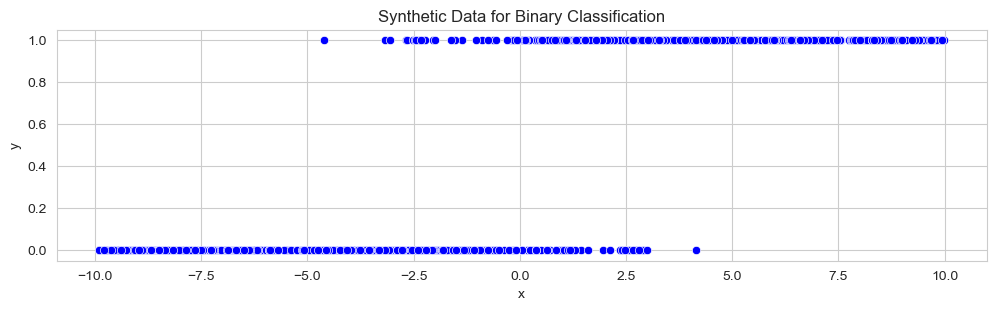

In [4]:
plt.figure(figsize=(12, 3))
sns.scatterplot(x=z_obs[:, 0], y=z_obs[:, 1], color='blue', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data for Binary Classification')
plt.show()

### Setup Functions

In [5]:
# Prediction Rule
def prediction_rule(x, w):
    h = w[0] + w[1] * x
    h = np.exp(h) / (1.0 + np.exp(h))
    return h

# Loss Function
def loss_fun(w, z):
    x, y = z
    h = prediction_rule(x, w)
    ell = -y * np.log(h) - (1 - y) * np.log(1 - h)
    return ell

# Gradient of Loss Function
def grad_loss_fun(w, z):
    x, y = z
    h = prediction_rule(x, w)
    grd = np.array([h - y, (h - y) * x])
    return grd

# Risk Function
def risk_fun(w, z, n):
    cum_loss = 0
    for i in range(n):
        cum_loss += loss_fun(w, z[i])
    
    return cum_loss / n

# Gradient of Risk Function
def grad_risk_fun(w, z, n):
    grd = np.zeros_like(w)
    for i in range(n):
        grd += grad_loss_fun(w, z[i, :])
    grd /= n
    return grd

### Gradient Function

In [6]:
def grad_fun(w):
    return grad_risk_fun(w, z_obs, n_obs)

## Basic Gradient Descent

In [7]:
w_opt, w_trace = basic_gd(grad_fun, (-1, 1.5), return_trace=True)

print(f"Optimum Weights: {w_opt}")

Optimum Weights: [-0.06398157  0.91725208]


### Trace Plot

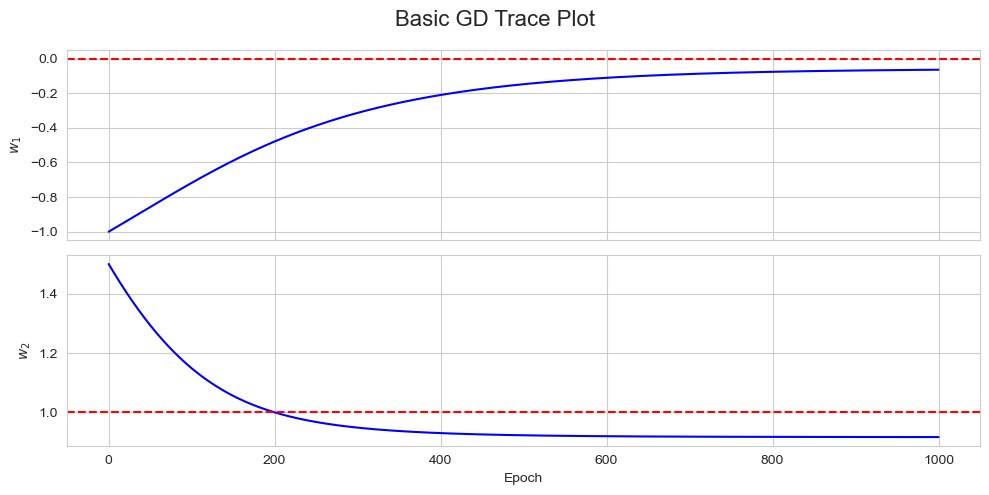

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

sns.lineplot(x=range(len(w_trace)), y=w_trace[:, 0], ax=ax1, color='blue')
ax1.set_ylabel('$w_1$')
ax1.axhline(y=w_true[0], color='red', linestyle='--')

sns.lineplot(x=range(len(w_trace)), y=w_trace[:, 1], ax=ax2, color='blue')
ax2.set_ylabel('$w_2$')
ax2.axhline(y=w_true[1], color='red', linestyle='--')
ax2.set_xlabel('Epoch')

fig.suptitle('Basic GD Trace Plot', fontsize=16)
plt.tight_layout()
plt.show()

The red lines mark the true values for `w` that underpin the data. These are not the minimums of the loss function though as the loss function depends on the specific training data we have.

### Path Plot

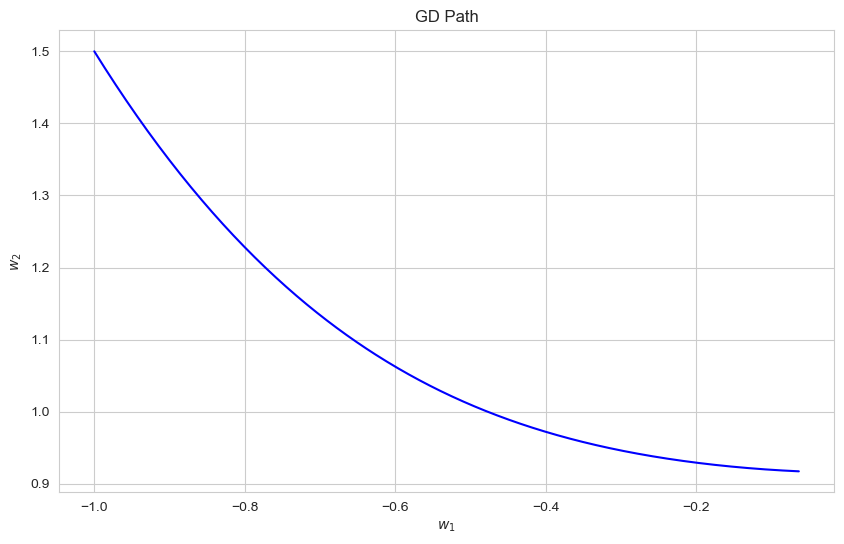

In [9]:
w_trace_df = pd.DataFrame(w_trace, columns=['w1', 'w2'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=w_trace_df, x='w1', y='w2', color='blue')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('GD Path')
plt.grid(True)
plt.show()

### Logistic Regression Solution

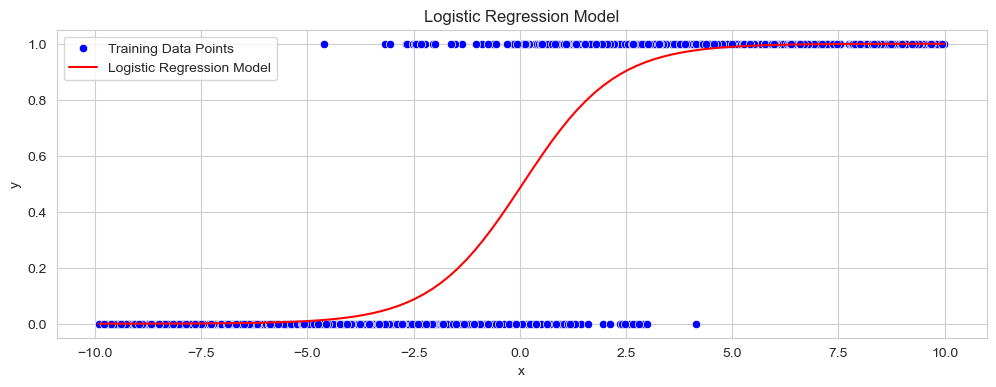

In [10]:
x_grid = np.linspace(np.min(z_obs[:, 0]), np.max(z_obs[:, 0]), 100)
lr_plot = prediction_rule(x_grid, w_opt)

plt.figure(figsize=(12, 4))
sns.scatterplot(x=z_obs[:, 0], y=z_obs[:, 1], color='blue', marker='o', label='Training Data Points')
plt.plot(x_grid, lr_plot, color='red', label='Logistic Regression Model')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Logistic Regression Model')
plt.legend()
plt.savefig('images/lr_model_plot', dpi=dpi)
plt.show()

## GD with Variable Learning Rate

In [11]:
def learning_rate(epoch):
    return (10 / (epoch + 1))

In [12]:
w_opt, w_trace = gd(grad_fun, (-1, 1.5), learning_rate, return_trace=True)

print(f"Optimum Weights: {w_opt}")

Optimum Weights: [-0.07898849  0.91802709]


## Batch SGD

First we need to modify the gradient function to work with the `batch_sgd` algorithm.

In [13]:
def grad_fun(w, batch):
    return grad_risk_fun(w, batch, len(batch))

We also write a more appropriate `learning_rate` function.

In [14]:
def learning_rate(epoch):
    eta = 3 / (epoch + 1)**0.5
    return eta

In [15]:
w_opt, w_trace = batch_sgd(grad_fun, z_obs, (-1, 1.5), learning_rate, batch_size=30,
                           max_epochs=2_000, return_trace=True)

print(f"Optimum Weights: {w_opt}")

Optimum Weights: [-0.0526172   0.90827118]


### Trace Plots

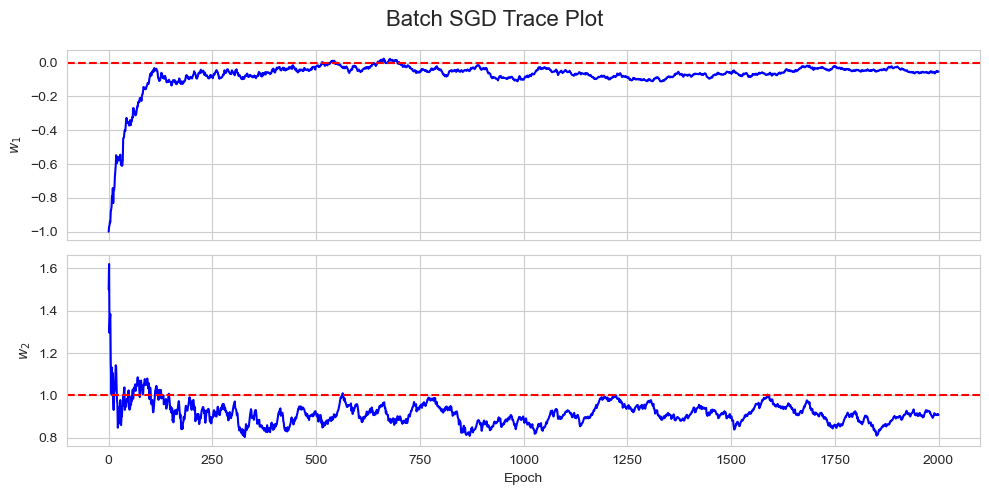

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

sns.lineplot(x=range(len(w_trace)), y=w_trace[:, 0], ax=ax1, color='blue')
ax1.set_ylabel('$w_1$')
ax1.axhline(y=w_true[0], color='red', linestyle='--')

sns.lineplot(x=range(len(w_trace)), y=w_trace[:, 1], ax=ax2, color='blue')
ax2.set_ylabel('$w_2$')
ax2.axhline(y=w_true[1], color='red', linestyle='--')
ax2.set_xlabel('Epoch')

fig.suptitle('Batch SGD Trace Plot', fontsize=16)
plt.tight_layout()
plt.savefig('images/bsgd_trace_plots', dpi=dpi)
plt.show()

### Path Plot with Risk Heatmap

In [17]:
def risk_fun_eval(w1, w2):
    w = (w1, w2)
    return risk_fun(w, z_obs, n_obs)

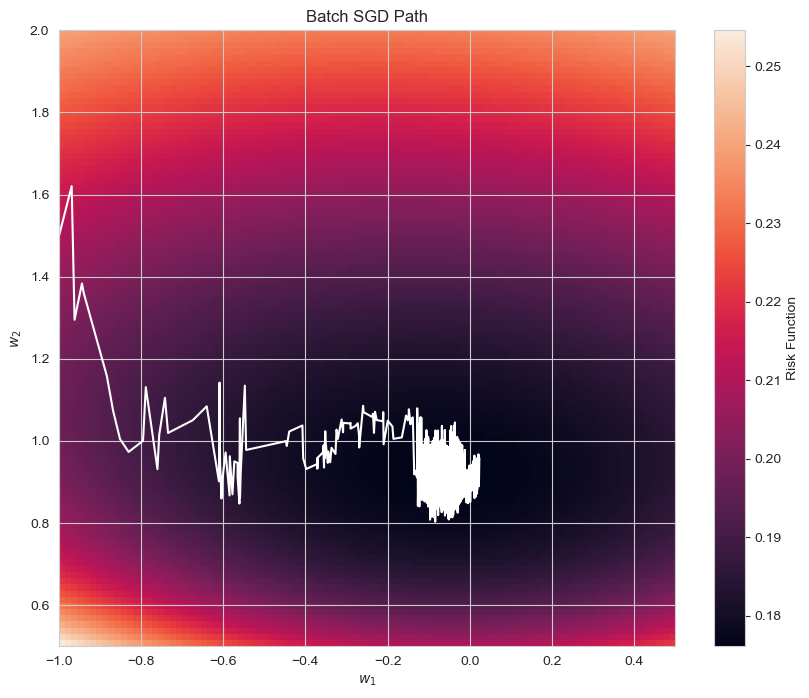

In [18]:
# Create a grid of x and y values using numpy meshgrid and evaluate the risk function at all pairs
W1, W2 = np.meshgrid(np.linspace(-1, 0.5, 100), np.linspace(0.5, 2, 100))
Z = risk_fun_eval(W1, W2)

# Create the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(Z, extent=[-1, 0.5, 0.5, 2], origin='lower')
plt.colorbar(label='Risk Function')

w_trace_df = pd.DataFrame(w_trace, columns=['w1', 'w2'])  # Create a DataFrame for w_trace
sns.lineplot(data=w_trace_df, x='w1', y='w2', color='white')  # Plot the SGD path on top of the heatmap

plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Batch SGD Path')
plt.grid(True)
plt.savefig('images/bsgd_path_heatmap', dpi=dpi)
plt.show()

## SGD with Projection

We now consider limiting our hypothesis space to where $w_2 \geq 0.9$. This projection could be much more complicated but would then possibly require some other optimisation algorithm to porject.

In [19]:
def projection_fun(w):
    w1, w2 = w[0], w[1]
    
    if w2 < 0.9:
        w2 = 0.9
    
    return np.array((w1, w2))

In [20]:
w_opt, w_trace = batch_sgd_projection(grad_fun, z_obs, (-1, 1.5), learning_rate, projection_fun, batch_size=30,
                           max_epochs=2_000, return_trace=True)

print(f"Optimum Weights: {w_opt}")

Optimum Weights: [-0.01364664  0.93393477]


### Trace Plots

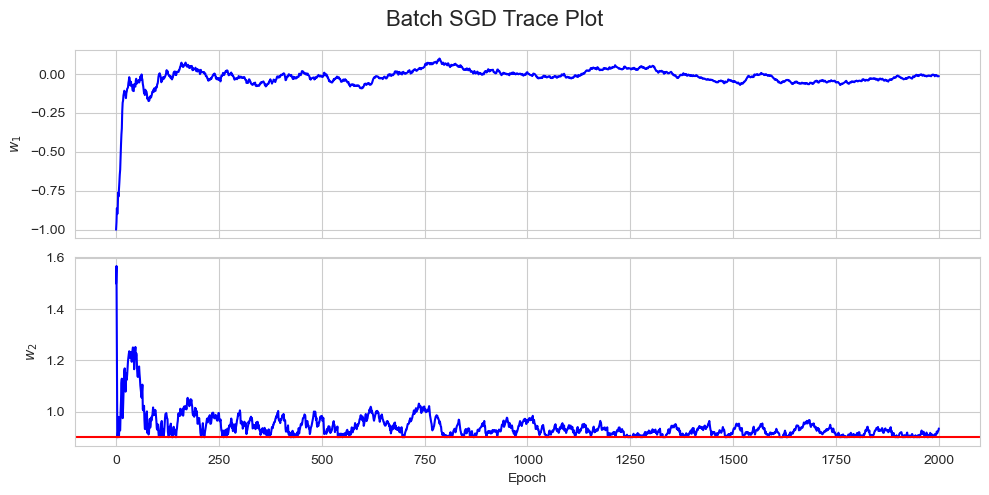

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

sns.lineplot(x=range(len(w_trace)), y=w_trace[:, 0], ax=ax1, color='blue')
ax1.set_ylabel('$w_1$')

sns.lineplot(x=range(len(w_trace)), y=w_trace[:, 1], ax=ax2, color='blue')
ax2.set_ylabel('$w_2$')
ax2.axhline(y=0.9, color='red', linestyle='-')  # projection boundary
ax2.set_xlabel('Epoch')

fig.suptitle('Batch SGD Trace Plot', fontsize=16)
plt.tight_layout()
plt.show()

### Path Plot with Heatmap

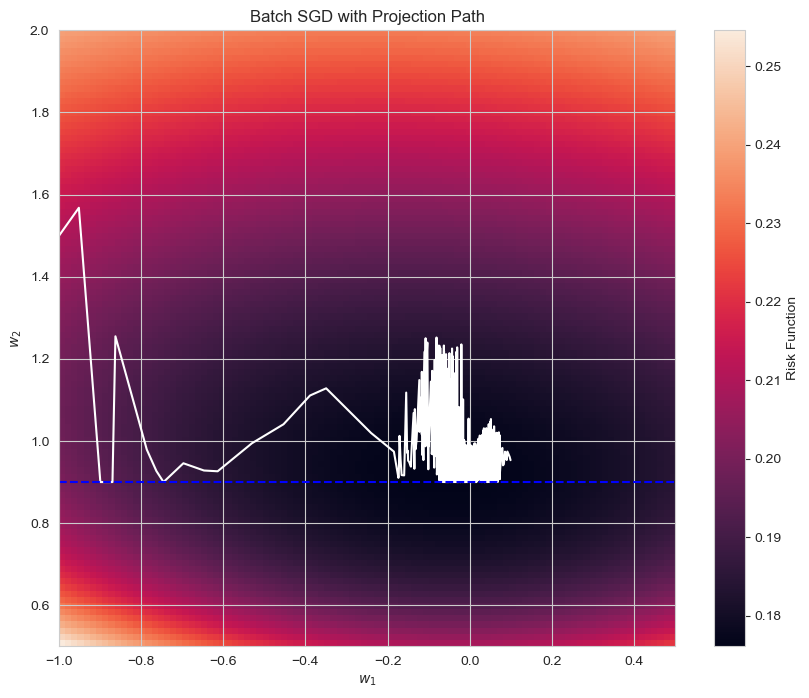

In [22]:
# Create a grid of x and y values using numpy meshgrid and evaluate the risk function at all pairs
W1, W2 = np.meshgrid(np.linspace(-1, 0.5, 100), np.linspace(0.5, 2, 100))
Z = risk_fun_eval(W1, W2)

# Create the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(Z, extent=[-1, 0.5, 0.5, 2], origin='lower')
plt.colorbar(label='Risk Function')

w_trace_df = pd.DataFrame(w_trace, columns=['w1', 'w2'])  # Create a DataFrame for w_trace
sns.lineplot(data=w_trace_df, x='w1', y='w2', color='white')  # Plot the SGD path on top of the heatmap

plt.axhline(y=0.9, color='b', linestyle='--', label='Projection Boundary')

plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Batch SGD with Projection Path')
plt.grid(True)
plt.savefig('images/bsgd_with_projection_path_heatmap', dpi=dpi)
plt.show()